In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pred = pd.read_csv("refined_cnn_lstm_predictionsl.csv")

# We ONLY trade on out-of-sample periods
pred = pred.sort_values("date").reset_index(drop=True)

p_use = pred["prob_up"]
ret   = pred["next_return"].fillna(0.0)

idx = pred.index


In [64]:
upper   = 0.55     # go fully long
lower   = 0.45     # go to cash
tcost   = 0.0002   # 2 bps transaction cost
max_lev = 1.5       # leverage cap
risk_levels = [0.05, 0.10, 0.15, 0.20]  # target annual vol


In [65]:
signal = pd.Series(0.0, index=idx)
signal[p_use >= upper] = 1.0
signal[(p_use > lower) & (p_use < upper)] = 0.5
# ≤ lower stays 0 (cash)


In [66]:
# Rolling volatility inside OOS only
vol_20d = ret.rolling(20).std()
annualised_vol = vol_20d * np.sqrt(252)


In [67]:
equity_curves = {}

for target_vol in risk_levels:

    # volatility-targeted position sizing
    w_raw = target_vol / annualised_vol
    w = w_raw.clip(lower=0.0, upper=max_lev)

    # final position = directional signal × vol targeting
    position = (signal * w).fillna(0.0)

    # shift to avoid look-ahead bias
    position_shifted = position.shift(1).fillna(0.0)

    # turnover cost
    turnover = position_shifted.diff().abs().fillna(0.0)

    # final daily P&L
    strat_ret = position_shifted * ret - tcost * turnover

    # equity curve
    equity_curves[target_vol] = (1 + strat_ret).cumprod()


In [68]:
bh_curve = (1 + ret).cumprod()


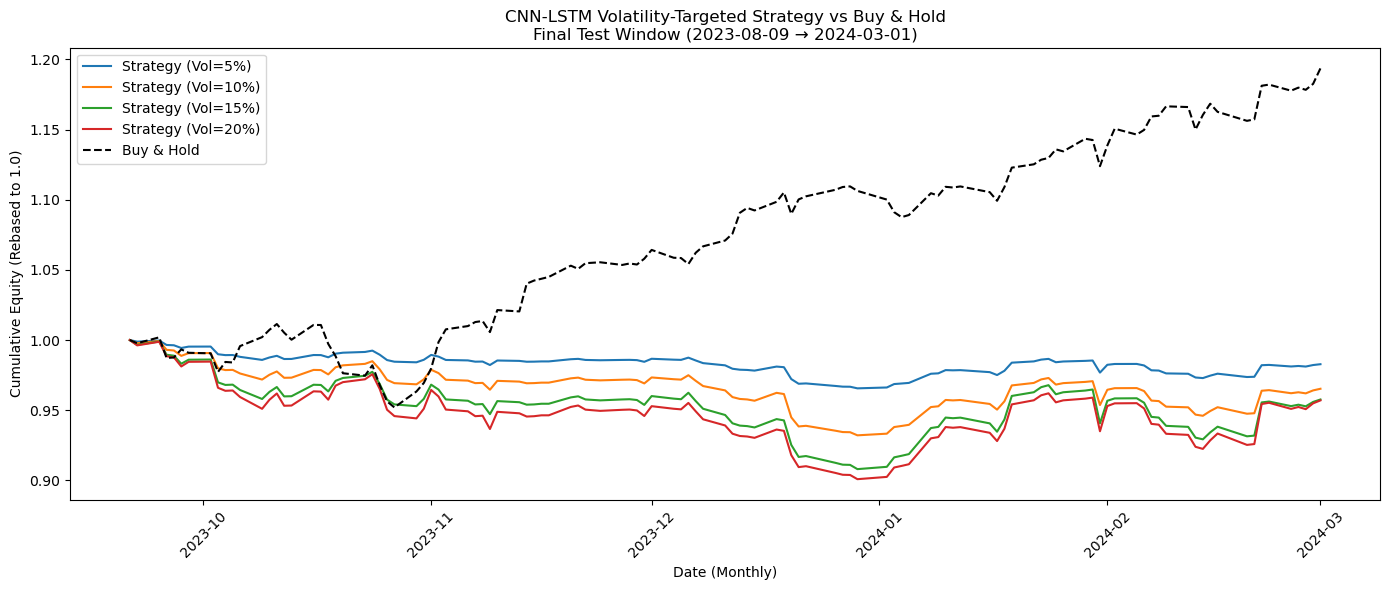

In [71]:
# ===============================
# NORMALIZE curves to start = 1.0
# ===============================
bh_sub = bh_sub / bh_sub.iloc[0]

equity_sub = {
    tv: curve / curve.iloc[0]
    for tv, curve in equity_sub.items()
}

# ===============================
# Plot
# ===============================

plt.figure(figsize=(14,6))

for tv, curve in equity_sub.items():
    plt.plot(curve.index, curve.values, label=f"Strategy (Vol={int(tv*100)}%)")

plt.plot(bh_sub.index, bh_sub.values, "--", color="black", label="Buy & Hold")

plt.title("CNN-LSTM Volatility-Targeted Strategy vs Buy & Hold\nFinal Test Window (2023-08-09 → 2024-03-01)")
plt.xlabel("Date (Monthly)")
plt.ylabel("Cumulative Equity (Rebased to 1.0)")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.grid(False)
plt.tight_layout()
plt.show()


C:\Users\malcolm\AppData\Local\Temp\ipykernel_12220\2573856164.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol_20d = vol_20d.fillna(method="bfill").fillna(vol_20d.mean())


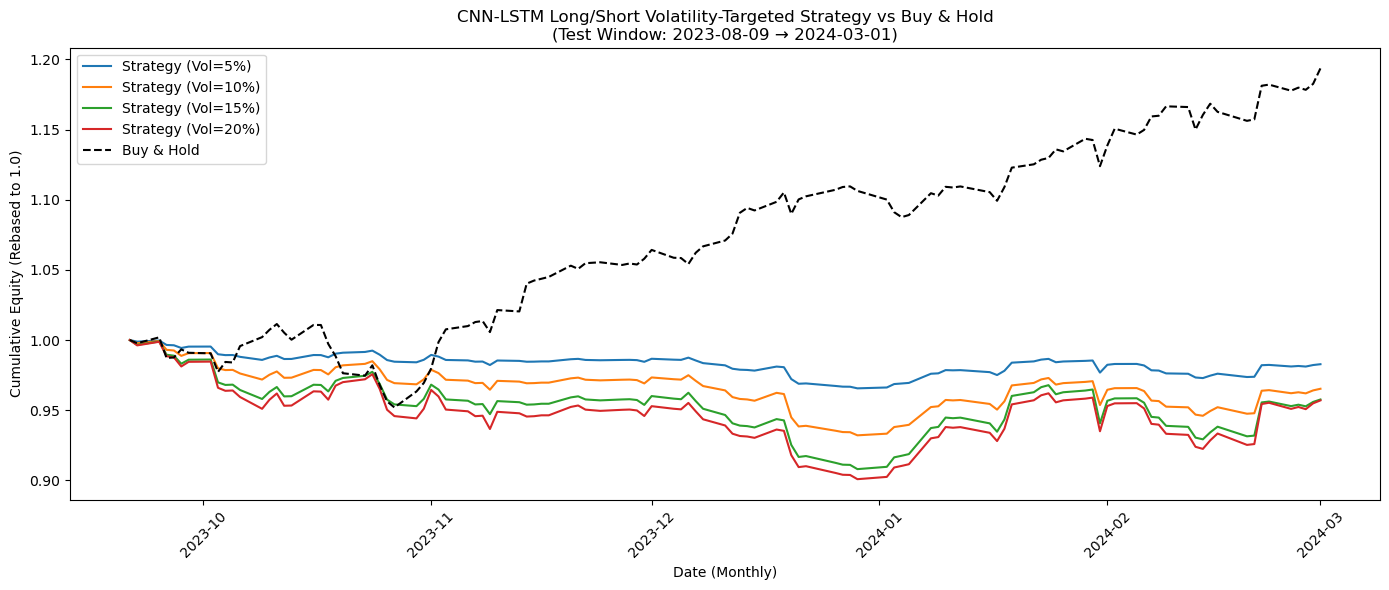

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============== 1. Load Test Predictions ===============
df_pred = pred.copy()
df_pred = df_pred.sort_values("date").reset_index(drop=True)

df_pred["date"] = pd.to_datetime(df_pred["date"])
dates = df_pred["date"]

prob_up = df_pred["prob_up"].values
ret     = df_pred["next_return"].fillna(0).values


# =============== 2. Long/Short Probability Signal in [-1, +1] ===============
d = 2 * (prob_up - 0.5)
d = np.clip(d, -1, 1)

df_pred["signal_raw"] = d


# =============== 3. Rolling Volatility ===============
df_pred["vol_20d"] = df_pred["next_return"].rolling(20).std()
vol_20d = df_pred["vol_20d"] * np.sqrt(252)
vol_20d = vol_20d.fillna(method="bfill").fillna(vol_20d.mean())


# =============== 4. Trading Parameters ===============
tcost = 0.0002
max_lev = 1.5
risk_levels = [0.05, 0.10, 0.15, 0.20]

equity_curves = {}


# =============== 5. Strategy Loop ===============
for target_vol in risk_levels:

    risk_scale = (target_vol / vol_20d).clip(0, max_lev)

    w_target = d * risk_scale
    w_apply  = np.hstack([[0], w_target[:-1]])

    dw = np.abs(np.diff(np.hstack([[0], w_apply])))

    strategy_ret = w_apply * ret - tcost * dw
    equity = np.cumprod(1 + strategy_ret)

    equity_curves[target_vol] = pd.Series(equity, index=dates)


# =============== 6. Buy & Hold ===============
bh_curve = pd.Series(np.cumprod(1 + ret), index=dates)


# =============== 7. Slice to EXACT WINDOW ===============

start = pd.to_datetime("2023-08-09")
end   = pd.to_datetime("2024-03-01")

# IMPORTANT: mask must use bh_curve.index, NOT the df_pred index
mask = (bh_curve.index >= start) & (bh_curve.index <= end)

bh_sub = bh_curve.loc[mask]

equity_sub = {
    tv: curve.loc[mask]
    for tv, curve in equity_curves.items()
}

dates_sub = bh_curve.index[mask]



# =============== 8. Rebase EVERYTHING to start at 1.0 ===============
bh_sub = bh_sub / bh_sub.iloc[0]

equity_sub = {
    tv: curve / curve.iloc[0]
    for tv, curve in equity_sub.items()
}


# =============== 9. Plot ===============
plt.figure(figsize=(14,6))

for tv, eq in equity_sub.items():
    plt.plot(eq.index, eq.values, label=f"Strategy (Vol={int(tv*100)}%)")

plt.plot(bh_sub.index, bh_sub.values, "--", color="black", label="Buy & Hold")

plt.title("CNN-LSTM Long/Short Volatility-Targeted Strategy vs Buy & Hold\n"
          "(Test Window: 2023-08-09 → 2024-03-01)")

plt.xlabel("Date (Monthly)")
plt.ylabel("Cumulative Equity (Rebased to 1.0)")
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.grid(False)
plt.tight_layout()
plt.show()
